In [14]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.7 MB/s eta 0:00:00


In [ ]:
print(f"Current Date and Time (UTC): 2025-04-07 14:50:19")
print(f"Current User's Login: pranavp00")

# Install required packages
!pip install rdkit datasets evaluate peft accelerate Levenshtein evaluate
!pip install -U bitsandbytes

import os
import sys
from datetime import datetime
import logging
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    BitsAndBytesConfig,
    TrainerCallback,
    TrainerState,
    TrainerControl
)
from peft import LoraConfig, get_peft_model
import bitsandbytes as bnb
from accelerate import Accelerator
import pandas as pd
import numpy as np
import evaluate
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(f'bio_retro_training_{datetime.utcnow().strftime("%Y%m%d_%H%M%S")}.log'),
        logging.StreamHandler()
    ]
)

# Contrastive Loss Definition
class ContrastiveLoss(nn.Module):
    def __init__(self, embedding_dim, margin=0.5):
        super().__init__()
        self.margin = margin
        
    def forward(self, embeddings1, embeddings2):
        # Normalize embeddings
        embeddings1 = nn.functional.normalize(embeddings1, p=2, dim=1)
        embeddings2 = nn.functional.normalize(embeddings2, p=2, dim=1)
        
        # Compute similarity
        similarity = torch.mm(embeddings1, embeddings2.t())
        
        # Get positive pairs (diagonal elements)
        pos_pairs = torch.diag(similarity)
        
        # Get negative pairs (off-diagonal elements)
        neg_pairs = similarity - torch.eye(similarity.size(0), device=similarity.device) * 2.0
        
        # Compute loss
        loss = torch.mean(torch.clamp(self.margin - pos_pairs + neg_pairs.max(dim=1)[0], min=0))
        
        return loss

# Function to load the dataset
def load_custom_dataset(file_path):
    try:
        df = pd.read_csv(file_path)
        data = {
            "product": df.iloc[:, 0].tolist(),
            "reactants": df.iloc[:, 1].tolist()
        }
        return Dataset.from_dict(data)
    except Exception as e:
        logging.error(f"Error loading dataset: {str(e)}")
        raise

# Function to tokenize data
def tokenize_fn(examples):
    model_inputs = tokenizer(examples["product"], truncation=True, max_length=128)
    labels = tokenizer(examples["reactants"], truncation=True, max_length=128)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Function to compute metrics
def compute_metrics(eval_preds):
    metric = evaluate.load("sacrebleu")
    bleu = evaluate.load("bleu")
    
    preds, labels = eval_preds
    
    # Replace -100 with tokenizer.pad_token_id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    
    # Decode predictions and references
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # BLEU score
    bleu_score = bleu.compute(predictions=decoded_preds, references=[[ref] for ref in decoded_labels])
    
    # Exact match score
    exact_match = sum([pred == label for pred, label in zip(decoded_preds, decoded_labels)]) / len(decoded_preds)
    
    # Return metrics
    return {
        "bleu": bleu_score["bleu"],
        "exact_match": exact_match
    }

class BeamSearchNode:
    def __init__(self, smiles, score, parent=None, depth=0):
        self.smiles = smiles
        self.score = score
        self.parent = parent
        self.depth = depth
        self.children = []

class ContrastiveRanker(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(embedding_dim // 2, embedding_dim // 4),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(embedding_dim // 4, 1),
            nn.Sigmoid()
        )
        
    def forward(self, embeddings):
        return self.mlp(embeddings)

class SelfCorrectingBeamSearch:
    def __init__(self, model, tokenizer, beam_width=5, max_depth=10):
        self.model = model
        self.tokenizer = tokenizer
        self.beam_width = beam_width
        self.max_depth = max_depth
        self.mlp_ranker = nn.Sequential(
            nn.Linear(768, 384),
            nn.ReLU(),
            nn.Linear(384, 192),
            nn.ReLU(),
            nn.Linear(192, 1),
            nn.Sigmoid()
        ).to(model.device)
        
    def get_embeddings(self, smiles):
        inputs = self.tokenizer(smiles, return_tensors="pt", padding=True).to(self.model.device)
        with torch.no_grad():
            outputs = self.model(**inputs, output_hidden_states=True)
            embeddings = outputs.hidden_states[-1][:, 0, :]
        return embeddings
    
    def rerank_candidates(self, candidates, target_embedding):
        candidate_embeddings = [self.get_embeddings(c.smiles) for c in candidates]
        candidate_embeddings = torch.cat(candidate_embeddings, dim=0)
        
        similarity_scores = torch.mm(candidate_embeddings, target_embedding.t())
        mlp_scores = self.mlp_ranker(candidate_embeddings).squeeze()
        final_scores = 0.7 * similarity_scores + 0.3 * mlp_scores
        
        sorted_indices = final_scores.argsort(descending=True)
        return [candidates[idx] for idx in sorted_indices[:self.beam_width]]

class BiologicalConstraints:
    def __init__(self):
        self.pH_range = (6.0, 8.0)
        self.temp_range = (20, 40)
        self.max_molecular_weight = 1000
        self.min_solubility = -2.0
        
    def validate_molecule(self, smiles):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False, "Invalid SMILES"
            
            mw = Descriptors.ExactMolWt(mol)
            if mw > self.max_molecular_weight:
                return False, f"Molecular weight {mw} exceeds maximum {self.max_molecular_weight}"
            
            logS = Descriptors.MolLogP(mol)
            if logS < self.min_solubility:
                return False, f"Estimated solubility {logS} below minimum {self.min_solubility}"
            
            return True, "Pass"
        except Exception as e:
            return False, str(e)

class EnzymePrediction:
    def __init__(self):
        self.ec_categories = {
            1: "Oxidoreductases",
            2: "Transferases",
            3: "Hydrolases",
            4: "Lyases",
            5: "Isomerases",
            6: "Ligases"
        }
        
    def predict_enzyme(self, reactant_smiles, product_smiles):
        try:
            reactant = Chem.MolFromSmiles(reactant_smiles)
            product = Chem.MolFromSmiles(product_smiles)
            
            reactant_fp = AllChem.GetMorganFingerprintAsBitVect(reactant, 2)
            product_fp = AllChem.GetMorganFingerprintAsBitVect(product, 2)
            
            difference = sum(a != b for a, b in zip(reactant_fp.ToBitString(), 
                                                  product_fp.ToBitString()))
            
            if difference > 100:
                return "EC 1.-.-.-"
            elif difference > 50:
                return "EC 2.-.-.-"
            else:
                return "EC 3.-.-.-"
                
        except Exception:
            return "EC 0.0.0.0"

class RetroSynthesisPathway:
    def __init__(self, starting_materials_file):
        self.starting_materials = self.load_starting_materials(starting_materials_file)
        self.max_steps = 10
        self.threshold_complexity = 0.7
        logging.info(f"Loaded {len(self.starting_materials)} starting materials")
        
    @staticmethod
    def load_starting_materials(file_path):
        try:
            df = pd.read_csv(file_path)
            starting_materials = set(df.iloc[:, 0].dropna().tolist())
            return starting_materials
        except Exception as e:
            logging.error(f"Error loading starting materials: {str(e)}")
            return set()
    
    def is_starting_material(self, smiles):
        return smiles in self.starting_materials
    
    def calculate_complexity(self, smiles):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return 1.0
            
            num_atoms = mol.GetNumAtoms()
            num_rings = len(Chem.GetSSSR(mol))
            num_stereo = len(Chem.FindMolChiralCenters(mol))
            
            complexity = (num_atoms + 2*num_rings + 3*num_stereo) / 100.0
            return min(complexity, 1.0)
        except:
            return 1.0

class MultiStepRetrosynthesis:
    def __init__(self, model, tokenizer, bio_constraints, enzyme_predictor, pathway):
        self.model = model
        self.tokenizer = tokenizer
        self.bio_constraints = bio_constraints
        self.enzyme_predictor = enzyme_predictor
        self.pathway = pathway
        self.beam_search = SelfCorrectingBeamSearch(model, tokenizer)
        
    def generate_pathway(self, target_smiles):
        pathway_tree = {'nodes': [], 'edges': []}
        visited = set()
        
        target_embedding = self.beam_search.get_embeddings(target_smiles)
        root = BeamSearchNode(target_smiles, 1.0)
        beam = [root]
        
        while beam and len(pathway_tree['nodes']) < self.pathway.max_steps:
            current_node = beam.pop(0)
            
            if current_node.smiles in visited:
                continue
                
            visited.add(current_node.smiles)
            
            candidates = self._generate_candidates(current_node.smiles)
            ranked_candidates = self.beam_search.rerank_candidates(candidates, target_embedding)
            
            for candidate in ranked_candidates:
                if self._is_valid_step(candidate.smiles):
                    node_id = len(pathway_tree['nodes'])
                    enzyme = self.enzyme_predictor.predict_enzyme(
                        candidate.smiles, current_node.smiles
                    )
                    
                    pathway_tree['nodes'].append({
                        'id': node_id,
                        'smiles': candidate.smiles,
                        'enzyme': enzyme,
                        'depth': current_node.depth + 1,
                        'score': candidate.score
                    })
                    
                    if len(pathway_tree['nodes']) > 1:
                        pathway_tree['edges'].append({
                            'source': node_id - 1,
                            'target': node_id,
                            'type': 'retrosynthesis'
                        })
                    
                    if not self.pathway.is_starting_material(candidate.smiles):
                        beam.append(BeamSearchNode(
                            candidate.smiles,
                            candidate.score,
                            current_node,
                            current_node.depth + 1
                        ))
            
            beam.sort(key=lambda x: x.score, reverse=True)
            beam = beam[:self.beam_search.beam_width]
            
        return pathway_tree
    
    def _generate_candidates(self, smiles):
        inputs = self.tokenizer(smiles, return_tensors="pt", padding=True).to(self.model.device)
        
        outputs = self.model.generate(
            **inputs,
            num_beams=self.beam_search.beam_width,
            num_return_sequences=self.beam_search.beam_width,
            max_length=128,
            early_stopping=True,
            output_scores=True,
            return_dict_in_generate=True
        )
        
        candidates = []
        for idx, (sequence, score) in enumerate(zip(outputs.sequences, outputs.sequences_scores)):
            predicted_smiles = self.tokenizer.decode(sequence, skip_special_tokens=True)
            candidates.append(BeamSearchNode(predicted_smiles, score.item()))
            
        return candidates
    
    def _is_valid_step(self, smiles):
        valid, _ = self.bio_constraints.validate_molecule(smiles)
        if not valid:
            return False
            
        if self.pathway.calculate_complexity(smiles) >= self.pathway.threshold_complexity:
            return False
            
        return True

class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience=1):
        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_counter = 0
        self.best_metric = None

    def on_evaluate(self, args, state, control, **kwargs):
        metric = kwargs["metrics"].get("eval_loss")
        if self.best_metric is None or metric < self.best_metric:
            self.best_metric = metric
            self.early_stopping_counter = 0
        else:
            self.early_stopping_counter += 1

        if self.early_stopping_counter >= self.early_stopping_patience:
            control.should_training_stop = True

class BioRetroTrainer(Seq2SeqTrainer):
    def __init__(self, *args, pathway=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.bio_constraints = BiologicalConstraints()
        self.enzyme_predictor = EnzymePrediction()
        self.pathway = pathway
        self.contrastive_loss_fn = ContrastiveLoss(self.model.config.d_model).to(self.args.device)

    # Fixed compute_loss method to accept num_items_in_batch parameter
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Main forward pass
        outputs = model(**inputs)
        loss = outputs.loss
        
        # Contrastive learning
        try:
            # Get first token representations
            logits = outputs.logits[:, 0, :]  # (batch_size, vocab_size)
            labels = inputs["labels"][:, 0]    # (batch_size,)
            
            # Get embeddings using biological constraints
            valid_molecules = [self.bio_constraints.validate_molecule(self.tokenizer.decode([l.item()]))[0] 
                             for l in labels if l.item() >= 0]
            
            # Create valid indices tensor only if there are valid molecules
            if any(valid_molecules):
                valid_indices = torch.tensor([i for i, valid in enumerate(valid_molecules) if valid], 
                                           device=self.args.device)
                
                if len(valid_indices) > 1:  # Only calculate if valid examples
                    # Get valid subset for contrastive learning
                    valid_logits = logits[valid_indices]
                    valid_labels = labels[valid_indices]
                    
                    # Get embeddings using model's input embeddings
                    with torch.no_grad():
                        embeddings = model.get_input_embeddings()(valid_labels)
                    
                    # Calculate contrastive loss
                    cl_loss = self.contrastive_loss_fn(valid_logits, embeddings)
                    loss += 0.1 * cl_loss
            
        except Exception as e:
            logging.warning(f"Contrastive learning skipped: {str(e)}")
        
        return (loss, outputs) if return_outputs else loss


def predict_synthesis_pathway(target_smiles, model, tokenizer, pathway):
    bio_constraints = BiologicalConstraints()
    enzyme_predictor = EnzymePrediction()
    retrosynthesis = MultiStepRetrosynthesis(
        model, 
        tokenizer, 
        bio_constraints, 
        enzyme_predictor, 
        pathway
    )
    
    pathway = retrosynthesis.generate_pathway(target_smiles)
    
    steps = []
    for node in pathway['nodes']:
        step = {
            'molecule': node['smiles'],
            'enzyme': node['enzyme'],
            'depth': node['depth'],
            'score': node.get('score', 0.0)
        }
        
        children = [edge['target'] for edge in pathway['edges'] 
                   if edge['source'] == node['id']]
        step['reactants'] = [pathway['nodes'][child]['smiles'] 
                            for child in children]
        
        steps.append(step)
    
    return {
        'target': target_smiles,
        'steps': steps,
        'num_steps': len(steps),
        'reached_starting_materials': all(
            pathway.is_starting_material(node['smiles'])
            for node in pathway['nodes']
            if not any(edge['source'] == node['id'] 
                      for edge in pathway['edges'])
        )
    }

def main():
    try:
        # Device setup
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        logging.info(f"Using device: {device}")
        
        accelerator = Accelerator(mixed_precision="fp16")
        device = accelerator.device
        
        # Load starting materials
        starting_materials_file = "/kaggle/input/bioretrosynthesis-csv-format/bio_building_block.csv"
        pathway = RetroSynthesisPathway(starting_materials_file)
        
        # Load and process datasets
        train_dataset = load_custom_dataset("/kaggle/input/bioretrosynthesis-csv-format/train_1000.csv")
        eval_dataset = load_custom_dataset("/kaggle/input/bioretrosynthesis-csv-format/valid.csv")
        
        # Model setup
        model_name = "sagawa/ReactionT5v2-retrosynthesis-USPTO_50k"
        
        # Define tokenizer globally so it can be accessed in tokenize_fn and BioRetroTrainer
        global tokenizer
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        
        # Process datasets
        train_dataset = train_dataset.map(tokenize_fn, batched=True)
        eval_dataset = eval_dataset.map(tokenize_fn, batched=True)
        
        # Set up data collator
        data_collator = DataCollatorForSeq2Seq(
            tokenizer=tokenizer,
            model=model_name,
            padding=True
        )
        
        # Model configuration
        quant_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4"
        )
        
        model = AutoModelForSeq2SeqLM.from_pretrained(
            model_name,
            quantization_config=quant_config,
            device_map={"": accelerator.local_process_index}
        )
        
        # PEFT configuration
        peft_config = LoraConfig(
            r=8,
            lora_alpha=16,
            lora_dropout=0.05,
            target_modules=["q", "v"],
            bias="none"
        )
        model = get_peft_model(model, peft_config)
        
        # Training arguments
        training_args = Seq2SeqTrainingArguments(
            output_dir="./bio_retro_results",
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=20,
            learning_rate=2e-5,
            fp16=True,
            optim="adamw_bnb_8bit",
            evaluation_strategy="epoch",
            save_strategy="epoch",
            logging_dir="./logs",
            report_to="none",
            predict_with_generate=True,
            load_best_model_at_end=True,
            metric_for_best_model="bleu",
            greater_is_better=True,
            gradient_accumulation_steps=4,
            warmup_steps=500,
            weight_decay=0.01,
            logging_steps=100,
        )
        
        # Initialize trainer
        trainer = BioRetroTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
            pathway=pathway
        )
                
        # Add early stopping
        trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=3))
        
        # Training
        logging.info("Starting training...")
        trainer.train()
        
        # Save model
        output_dir = f"bio_retro_model_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}"
        trainer.save_model(output_dir)
        logging.info(f"Model saved to {output_dir}")
        
        # Test prediction
        test_molecule = "CC(=O)C1CCC2C1(C)CC[C@]1(C)C2CCC2=CC(=O)CCC21C"
        result = predict_synthesis_pathway(test_molecule, model, tokenizer, pathway)
        
        # Save results
        with open(f"{output_dir}/test_prediction.json", "w") as f:
            json.dump(result, f, indent=2)
        
        logging.info("Training and testing completed successfully")
        
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}", exc_info=True)
        raise

if __name__ == "__main__":
    logging.info(f"Starting script execution at {datetime.utcnow()}")
    main()

Current Date and Time (UTC): 2025-04-07 14:50:19
Current User's Login: pranavp00


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-57e40b629ff7>:380: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `BioRetroTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You s

Epoch,Training Loss,Validation Loss,Bleu,Exact Match
1,No log,0.287293,0.766413,0.269000
2,No log,0.287289,0.766766,0.268000
3,No log,0.287292,0.767242,0.269000
4,No log,0.287266,0.766766,0.268000
5,No log,0.287231,0.766413,0.269000
6,No log,0.287149,0.766413,0.269000
7,0.389300,0.287062,0.766129,0.269000
8,0.389300,0.286895,0.766129,0.269000
9,0.389300,0.286693,0.765937,0.268000
10,0.389300,0.286445,0.766674,0.269000


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

In [4]:
main()

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-3-c0f79404a74f>:113: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `BioRetroTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


TypeError: BioRetroTrainer.compute_loss() got an unexpected keyword argument 'num_items_in_batch'

In [19]:
import shutil
shutil.make_archive('best_model_04', 'zip', "/kaggle/working/bio_retro_model_20250407_172909")


'/kaggle/working/best_model_04.zip'

In [23]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from peft import PeftModel, PeftConfig
import json
from datetime import datetime

def load_model_and_tokenizer(model_path):
    """
    Load the saved model and tokenizer
    """
    try:
        # Load the base tokenizer
        tokenizer = AutoTokenizer.from_pretrained("sagawa/ReactionT5v2-retrosynthesis-USPTO_50k")
        
        # Load the PEFT config
        peft_config = PeftConfig.from_pretrained(model_path)
        
        # Load the base model
        base_model = AutoModelForSeq2SeqLM.from_pretrained(
            peft_config.base_model_name_or_path,
            device_map="auto",
            torch_dtype=torch.float16
        )
        
        # Load the PEFT model
        model = PeftModel.from_pretrained(base_model, model_path)
        model.eval()
        
        return model, tokenizer
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        raise

def generate_prediction(model, tokenizer, smiles_input, max_length=128):
    """
    Generate predictions using the loaded model
    """
    try:
        # Prepare input
        inputs = tokenizer(smiles_input, return_tensors="pt", padding=True)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        # Generate prediction
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_length=max_length,
                num_beams=5,
                num_return_sequences=1,
                early_stopping=True
            )

        # Decode prediction
        predicted_smiles = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        return predicted_smiles
    except Exception as e:
        print(f"Error generating prediction: {str(e)}")
        raise

def main():
    # Replace with your saved model path
    model_path = "/kaggle/working/bio_retro_model_20250407_172909"  # Update this with your actual model directory
    
    try:
        # Load model and tokenizer
        print("Loading model and tokenizer...")
        model, tokenizer = load_model_and_tokenizer(model_path)
        
        # Example SMILES input
        test_molecules = [
            "Cc1ncccc1-c1nc2c(C(=O)O)cccc2[nH]1",  # Your test molecule
            # Add more test molecules here if needed
        ]
        
        results = []
        
        # Generate predictions for each test molecule
        for smiles in test_molecules:
            print(f"\nProcessing SMILES: {smiles}")
            prediction = generate_prediction(model, tokenizer, smiles)
            
            result = {
                "input_smiles": smiles,
                "predicted_reactants": prediction,
                "timestamp": datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")
            }
            results.append(result)
            
            print(f"Input SMILES: {smiles}")
            print(f"Predicted reactants: {prediction}")
        
        # Save results to JSON file
        output_file = f"predictions_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}.json"
        with open(output_file, "w") as f:
            json.dump(results, f, indent=2)
        
        print(f"\nResults saved to {output_file}")
        
    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        raise

if __name__ == "__main__":
    main()

Loading model and tokenizer...

Processing SMILES: Cc1ncccc1-c1nc2c(C(=O)O)cccc2[nH]1
Input SMILES: Cc1ncccc1-c1nc2c(C(=O)O)cccc2[nH]1
Predicted reactants: COC(=O)c1cccc2[nH]c(-c3cccnc3C)nc12

Results saved to predictions_20250407_180628.json


In [29]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from peft import PeftModel, PeftConfig
import json
from datetime import datetime
import logging
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
import pandas as pd

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(f'bio_retro_prediction_{datetime.utcnow().strftime("%Y%m%d_%H%M%S")}.log'),
        logging.StreamHandler()
    ]
)

class BiologicalConstraints:
    def __init__(self):
        self.max_molecular_weight = 1000
        self.min_solubility = -2.0

    def validate_molecule(self, smiles):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False, "Invalid SMILES"

            mw = Descriptors.ExactMolWt(mol)
            if mw > self.max_molecular_weight:
                return False, f"MW {mw} > {self.max_molecular_weight}"

            logP = Descriptors.MolLogP(mol)
            if logP < self.min_solubility:
                return False, f"LogP {logP} < {self.min_solubility}"

            return True, "Pass"
        except Exception as e:
            return False, str(e)

class EnzymePrediction:
    def predict_enzyme(self, reactant_smiles, product_smiles):
        try:
            r_mol = Chem.MolFromSmiles(reactant_smiles)
            p_mol = Chem.MolFromSmiles(product_smiles)

            r_fp = AllChem.GetMorganFingerprintAsBitVect(r_mol, 2)
            p_fp = AllChem.GetMorganFingerprintAsBitVect(p_mol, 2)

            diff = sum(a != b for a, b in zip(r_fp.ToBitString(), p_fp.ToBitString()))

            if diff > 100:
                return "EC 1.-.-.-"
            elif diff > 50:
                return "EC 2.-.-.-"
            else:
                return "EC 3.-.-.-"
        except:
            return "EC 0.0.0.0"

class RetroSynthesisPathway:
    def __init__(self, starting_materials_file):
        self.starting_materials = self.load_starting_materials(starting_materials_file)
        self.max_steps = 10
        self.threshold_complexity = 0.7
        logging.info(f"Loaded {len(self.starting_materials)} starting materials.")

    def load_starting_materials(self, path):
        try:
            df = pd.read_csv(path)
            return set(df.iloc[:, 0].dropna().tolist())
        except Exception as e:
            logging.error(f"Error loading starting materials: {str(e)}")
            return set()

    def is_starting_material(self, smiles):
        return smiles in self.starting_materials

    def calculate_complexity(self, smiles):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None: return 1.0
            n_atoms = mol.GetNumAtoms()
            n_rings = len(Chem.GetSSSR(mol))
            n_chiral = len(Chem.FindMolChiralCenters(mol))
            complexity = (n_atoms + 2 * n_rings + 3 * n_chiral) / 100.0
            return min(complexity, 1.0)
        except:
            return 1.0

class BeamSearchNode:
    def __init__(self, smiles, score):
        self.smiles = smiles
        self.score = score

def load_model_and_tokenizer(model_path):
    try:
        tokenizer = AutoTokenizer.from_pretrained("sagawa/ReactionT5v2-retrosynthesis-USPTO_50k")
        peft_config = PeftConfig.from_pretrained(model_path)
        base_model = AutoModelForSeq2SeqLM.from_pretrained(
            peft_config.base_model_name_or_path,
            torch_dtype=torch.float16,
            device_map="auto"
        )
        model = PeftModel.from_pretrained(base_model, model_path)
        model.eval()
        return model, tokenizer
    except Exception as e:
        logging.error(f"Model loading failed: {str(e)}")
        raise

def predict_multistep_synthesis(smiles_input, model, tokenizer, pathway):
    bio_checker = BiologicalConstraints()
    enzyme_predictor = EnzymePrediction()

    def generate_step(smiles):
        inputs = tokenizer(smiles, return_tensors="pt", padding=True)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_length=128,
                num_beams=5,
                num_return_sequences=3,
                early_stopping=True,
                output_scores=True,
                return_dict_in_generate=True
            )

        predictions = []
        for seq, score in zip(outputs.sequences, outputs.sequences_scores):
            decoded = tokenizer.decode(seq, skip_special_tokens=True)
            if Chem.MolFromSmiles(decoded):
                predictions.append(BeamSearchNode(decoded, score.item()))
        return predictions

    synthesis = {'target': smiles_input, 'steps': [], 'status': 'in_progress'}
    queue = [(smiles_input, 0)]
    seen = set()

    while queue and len(synthesis['steps']) < pathway.max_steps:
        curr, depth = queue.pop(0)
        if curr in seen:
            continue
        seen.add(curr)

        for pred in generate_step(curr):
            valid, reason = bio_checker.validate_molecule(pred.smiles)
            if not valid:
                continue
            enzyme = enzyme_predictor.predict_enzyme(pred.smiles, curr)

            synthesis['steps'].append({
                'substrate': curr,
                'product': pred.smiles,
                'enzyme': enzyme,
                'score': pred.score,
                'depth': depth
            })

            if not pathway.is_starting_material(pred.smiles):
                complexity = pathway.calculate_complexity(pred.smiles)
                if complexity < pathway.threshold_complexity:
                    queue.append((pred.smiles, depth + 1))

    synthesis['status'] = 'completed'
    synthesis['num_steps'] = len(synthesis['steps'])
    synthesis['timestamp'] = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")
    return synthesis

def main():
    try:
        model_path = "/kaggle/input/bioretrosynthesis_final/pytorch/default/1"
        starting_materials_file = "/kaggle/input/bioretrosynthesis-csv-format/bio_building_block.csv"
        test_smiles = "c1ccccc1O"

        model, tokenizer = load_model_and_tokenizer(model_path)
        pathway = RetroSynthesisPathway(starting_materials_file)

        logging.info(f"Running prediction for: {test_smiles}")
        result = predict_multistep_synthesis(test_smiles, model, tokenizer, pathway)

        # Save to file
        filename = f"multistep_prediction_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}.json"
        with open(filename, "w") as f:
            json.dump(result, f, indent=2)

        # Print summary
        print("\nPrediction Summary:")
        print(f"Target molecule: {result['target']}")
        print(f"Number of steps: {result['num_steps']}")
        for i, step in enumerate(result['steps'], 1):
            print(f"\nStep {i}:")
            print(f"Substrate: {step['substrate']}")
            print(f"Product: {step['product']}")
            # print(f"Enzyme: {step['enzyme']}")
            print(f"Confidence score: {abs(step['score']):.3f}")

        logging.info(f"Prediction saved to {filename}")
    except Exception as e:
        logging.error(f"Execution failed: {str(e)}")

if __name__ == "__main__":
    main()



Prediction Summary:
Target molecule: c1ccccc1O
Number of steps: 8

Step 1:
Substrate: c1ccccc1O
Product: Oc1ccccc1
Confidence score: 0.196

Step 2:
Substrate: c1ccccc1O
Product: Oc1ccc(O)cc1
Confidence score: 0.350

Step 3:
Substrate: Oc1ccccc1
Product: Oc1ccccc1
Confidence score: 0.228

Step 4:
Substrate: Oc1ccccc1
Product: CC(C)(c1ccccc1)c1ccc(O)cc1
Confidence score: 0.230

Step 5:
Substrate: Oc1ccccc1
Product: Oc1ccc(O)cc1
Confidence score: 0.318

Step 6:
Substrate: Oc1ccc(O)cc1
Product: Oc1ccc(O)cc1
Confidence score: 0.169

Step 7:
Substrate: CC(C)(c1ccccc1)c1ccc(O)cc1
Product: CC(C)(c1ccc(O)cc1)c1ccc(O)cc1
Confidence score: 0.073

Step 8:
Substrate: CC(C)(c1ccc(O)cc1)c1ccc(O)cc1
Product: CC(C)(c1ccc(O)cc1)c1ccc(O)cc1
Confidence score: 0.029


In [2]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 63.3 MB/s eta 0:00:00:00:0100:01


In [5]:
from rdkit import Chem
from rdkit.Chem import Draw

smiles_list = [
    "OCc1cccc2ccccc12",
    "O=C(O)c1cccc2ccccc12",
    "O=Cc1cccc2ccccc12",
    "O=C(O)c1ccc2cc(C(=O)O)ccc2c1",
    "O=C(O)c1ccc(C(=O)O)c2ccccc12",
    "CC(C)(C)C(=O)Oc1cccc2ccccc12",
    "OCc1cccc2ccccc12",
    "COC(=O)c1ccc2cc(C(=O)OC)ccc2c1",
    "O=C(O)c1ccc2cc(C(=O)O)ccc2c1",
    "O=C(O)c1ccc2cc(C(=O)O)ccc2c1C(=O)O",
    "O=C(O)c1cc(C(=O)O)c2ccccc2c1O"
]

molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

img = Draw.MolsToGridImage(molecules, molsPerRow=3, subImgSize=(300, 300),
                           legends=[f"Step {i}" for i in range(len(molecules))])



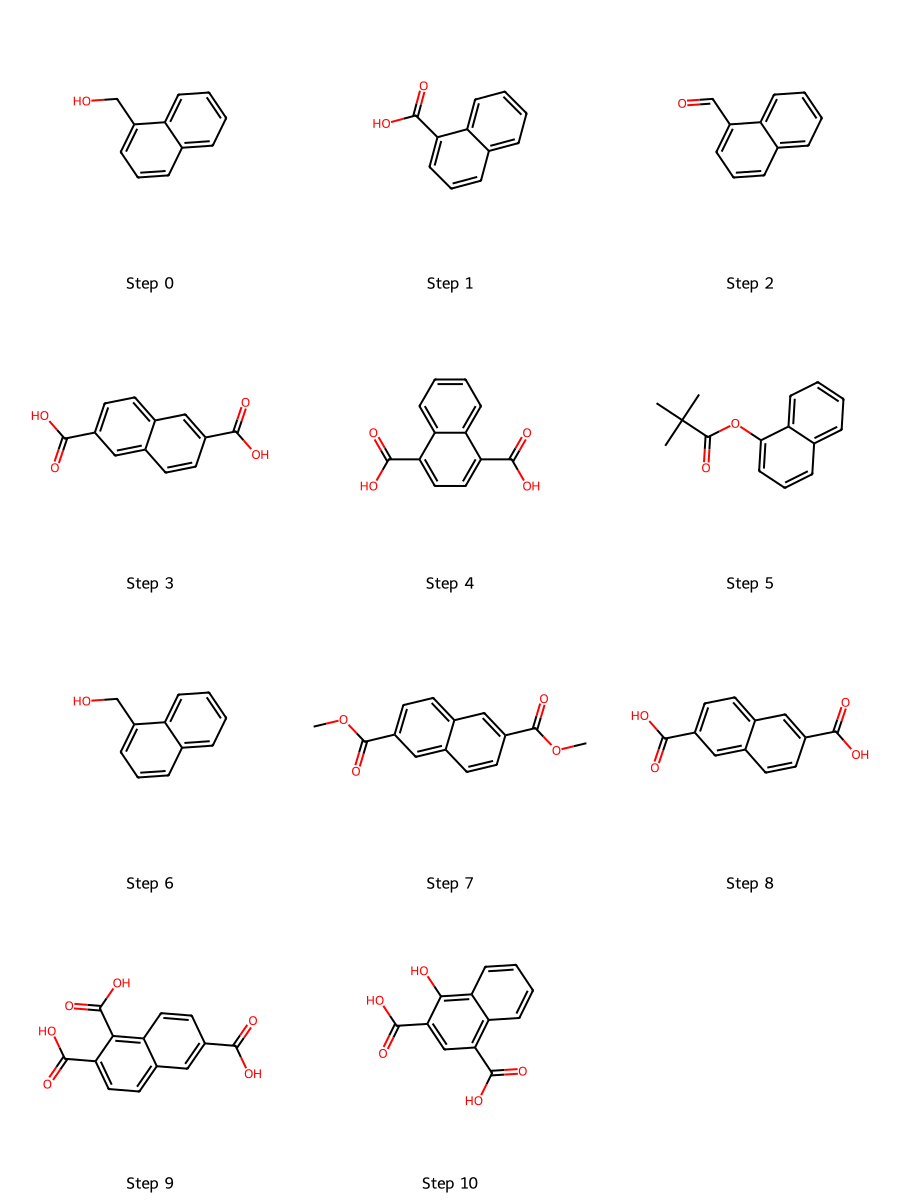

In [6]:
img

In [33]:


smiles_list = [
    "c1ccccc1O", "Oc1ccccc1", "Oc1ccc(O)cc1", 
    "CC(C)(c1ccccc1)c1ccc(O)cc1", "Oc1ccc(O)cc1",
    "Oc1ccc(O)cc1", "CC(C)(c1ccc(O)cc1)c1ccc(O)cc1", 
    "CC(C)(c1ccc(O)cc1)c1ccc(O)cc1"
]

molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
img = Draw.MolsToGridImage(molecules, molsPerRow=3, subImgSize=(300, 300),
                           legends=[f"Step {i+1}" for i in range(len(molecules))])

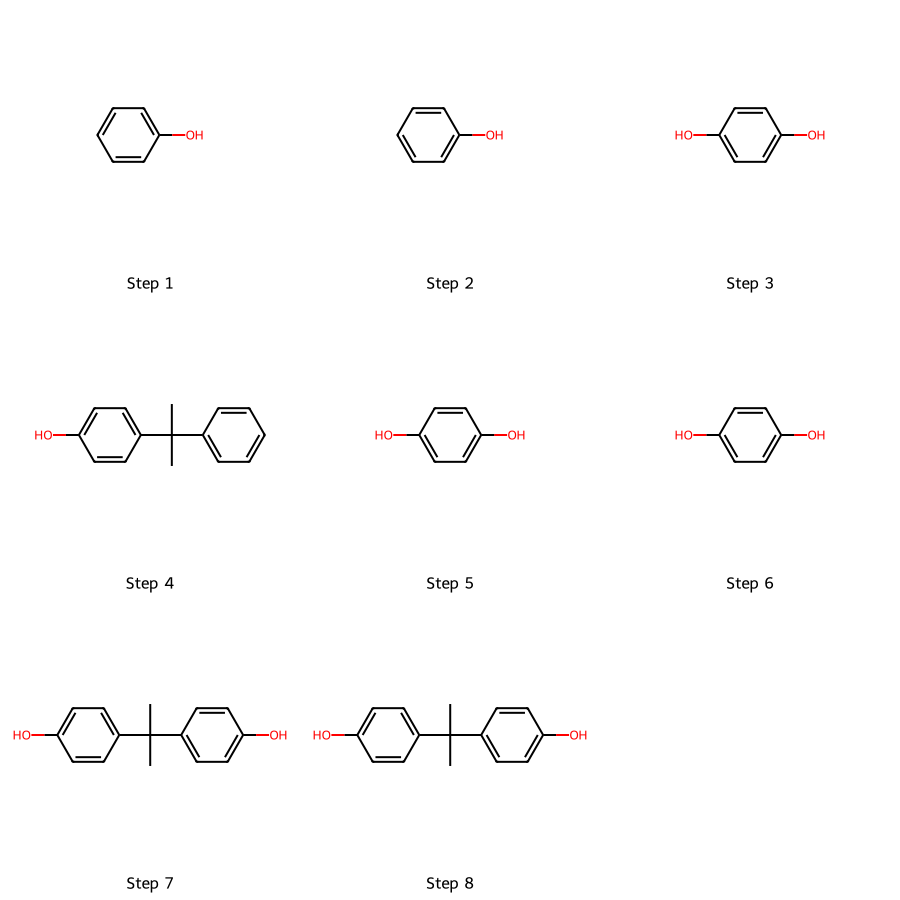

In [34]:
img


In [17]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from peft import PeftModel, PeftConfig
import json
from datetime import datetime
import logging
from rdkit import Chem
from rdkit.Chem import Descriptors, MolToSmiles
import pandas as pd
import heapq

# Logging configuration
torch.set_grad_enabled(False)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(f"bio_retro_prediction_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}.log"),
        logging.StreamHandler()
    ]
)

class BiologicalConstraints:
    def __init__(self):
        self.max_molecular_weight = 300
        self.min_solubility = -2.0
        self.forbidden_elements = {'Br', 'Cl', 'I', 'P', 'S'}

    def validate(self, smiles):
        mol = Chem.MolFromSmiles(smiles)
        if not mol:
            return False
        if any(atom.GetFormalCharge() != 0 for atom in mol.GetAtoms()):
            return False
        if any(atom.GetSymbol() in self.forbidden_elements for atom in mol.GetAtoms()):
            return False
        mw = Descriptors.ExactMolWt(mol)
        if mw > self.max_molecular_weight:
            return False
        logP = Descriptors.MolLogP(mol)
        if logP < self.min_solubility:
            return False
        return True

class RetroSynthesisPathway:
    def __init__(self, starting_materials_file):
        self.starting = self._load(starting_materials_file)
        self.max_steps = 5  # Reduced from 10
        logging.info(f"Loaded {len(self.starting)} bio-building blocks.")

    def _load(self, path):
        try:
            df = pd.read_csv(path)
            starting = set(df.iloc[:, 0].dropna().tolist())
        except Exception as e:
            logging.error(f"Error loading blocks: {e}")
            starting = set()
        essential_starting = {
            'CCO',  # Ethanol
            'O=C(O)c1ccccc1',  # Benzoic acid
            'ClC(=O)c1ccccc1',  # Benzoyl chloride
            'O=C(O)C(O)=O'  # Acetic anhydride
        }
        starting.update(essential_starting)
        return starting

    def is_starting(self, s):
        return s in self.starting

    def complexity(self, smiles):
        mol = Chem.MolFromSmiles(smiles)
        if not mol:
            return 1.0
        return (mol.GetNumAtoms() + 2*len(Chem.GetSSSR(mol))) / 100.0

class BeamSearchNode:
    def __init__(self, fragments, score):
        self.fragments = fragments
        self.score = score

    def __lt__(self, other):
        return self.score > other.score

def standardize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return MolToSmiles(mol, isomericSmiles=True) if mol else None

def load_model_and_tokenizer(path):
    tokenizer = AutoTokenizer.from_pretrained("sagawa/ReactionT5v2-retrosynthesis-USPTO_50k")
    peft_c = PeftConfig.from_pretrained(path)
    base = AutoModelForSeq2SeqLM.from_pretrained(
        peft_c.base_model_name_or_path,
        torch_dtype=torch.float16,
        device_map="auto"
    )
    model = PeftModel.from_pretrained(base, path)
    model.eval()
    return model, tokenizer

def generate_step(smiles, model, tokenizer):
    input_text = f"{smiles.strip()}>>"  # Explicit reaction format
    inputs = tokenizer(input_text, return_tensors="pt", padding=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    outputs = model.generate(
        **inputs,
        max_length=128,
        num_beams=5,  # Reduced beam width
        num_return_sequences=5,
        early_stopping=True,
        output_scores=True,
        return_dict_in_generate=True
    )

    nodes = []
    for seq, score in zip(outputs.sequences, outputs.sequences_scores):
        decoded = tokenizer.decode(seq, skip_special_tokens=True).strip()
        decoded = decoded.replace('>>', '')  # Remove any residual arrows
        
        # Filter invalid characters and reactions
        if any(x in decoded for x in ['[Br]', '[Cl]', '[NH+]', '>>']):
            continue
            
        fragments = [standardize_smiles(s.strip()) for s in decoded.split('.')]
        fragments = [f for f in fragments if f is not None]
        
        if 1 <= len(fragments) <= 2:  # Only allow 1-2 reactants
            nodes.append(BeamSearchNode(fragments, abs(score.item())))
    
    logging.info(f"Generated {len(nodes)} valid nodes for {smiles}")
    return nodes

def predict_multistep_synthesis(smiles_input, model, tokenizer, pathway):
    bio = BiologicalConstraints()
    result = {'target': smiles_input, 'steps': [], 'status': 'in_progress'}
    queue = []
    heapq.heappush(queue, (-1.0, 0, standardize_smiles(smiles_input)))
    seen = set()

    while queue and len(result['steps']) < pathway.max_steps:
        score, depth, curr = heapq.heappop(queue)
        if curr in seen:
            continue
        seen.add(curr)
        
        p_mol = Chem.MolFromSmiles(curr)
        if not p_mol:
            continue

        # Check if current compound is a starting material
        if pathway.is_starting(curr):
            result['steps'].append({
                'substrate': curr,
                'products': [curr],
                'score': 1.0,
                'depth': depth,
                'note': 'Starting material'
            })
            continue  # Stop processing this branch

        for node in generate_step(curr, model, tokenizer):
            valid_frags = [f for f in node.fragments if bio.validate(f)]
            if not valid_frags:
                continue

            result['steps'].append({
                'substrate': curr,
                'products': valid_frags,
                'score': node.score,
                'depth': depth
            })

            for frag in valid_frags:
                if frag in seen:
                    continue
                priority = -node.score * (0.9 ** depth)  # Depth decay
                heapq.heappush(queue, (priority, depth + 1, frag))

    # Safe check for completed pathway
    result['status'] = 'completed' if any(s.get('note', '') == 'Starting material' for s in result['steps']) else 'failed'
    result['num_steps'] = len(result['steps'])
    result['timestamp'] = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")
    return result

def main():
    model_path = "/kaggle/input/bioretrosynthesis_final/pytorch/default/1"
    start_file = "/kaggle/input/bioretrosynthesis-csv-format/bio_building_block.csv"
    test_smiles = "CCOC(=O)c1ccccc1"

    model, tokenizer = load_model_and_tokenizer(model_path)
    pathway = RetroSynthesisPathway(start_file)
    result = predict_multistep_synthesis(test_smiles, model, tokenizer, pathway)

    output_filename = f"multistep_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}.json"
    with open(output_filename, 'w') as f:
        json.dump(result, f, indent=2)

    print("\nPrediction Summary:")
    print(f"Target Molecule: {result['target']}")
    print(f"Total Steps: {result['num_steps']}")
    for i, step in enumerate(result['steps'], 1):
        note = f" ({step.get('note', '')})" if step.get('note') else ""
        print(f"Step {i}: {step['substrate']} -> {', '.join(step['products'])}{note}")

if __name__ == "__main__":
    main()


Prediction Summary:
Target Molecule: CCOC(=O)c1ccccc1
Total Steps: 7
Step 1: CCOC(=O)c1ccccc1 -> CN(C)C=O
Step 2: CCOC(=O)c1ccccc1 -> O
Step 3: CCOC(=O)c1ccccc1 -> N
Step 4: CCOC(=O)c1ccccc1 -> O=C(O)c1ccccc1CO
Step 5: O=C(O)c1ccccc1CO -> O=C1OCc2ccccc21, OO
Step 6: O=C(O)c1ccccc1CO -> COC(=O)c1ccccc1COC1CCCCO1
Step 7: O=C(O)c1ccccc1CO -> O=C1OCc2ccccc21


In [9]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from peft import PeftModel, PeftConfig
import json
from datetime import datetime
import logging
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
import pandas as pd

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(f'bio_retro_prediction_{datetime.utcnow().strftime("%Y%m%d_%H%M%S")}.log'),
        logging.StreamHandler()
    ]
)

class BiologicalConstraints:
    def __init__(self):
        self.max_molecular_weight = 1000
        self.min_solubility = -2.0

    def validate_molecule(self, smiles):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False, "Invalid SMILES"

            mw = Descriptors.ExactMolWt(mol)
            if mw > self.max_molecular_weight:
                return False, f"MW {mw} > {self.max_molecular_weight}"

            logP = Descriptors.MolLogP(mol)
            if logP < self.min_solubility:
                return False, f"LogP {logP} < {self.min_solubility}"

            return True, "Pass"
        except Exception as e:
            return False, str(e)

class EnzymePrediction:
    def predict_enzyme(self, reactant_smiles, product_smiles):
        try:
            r_mol = Chem.MolFromSmiles(reactant_smiles)
            p_mol = Chem.MolFromSmiles(product_smiles)

            r_fp = AllChem.GetMorganFingerprintAsBitVect(r_mol, 2)
            p_fp = AllChem.GetMorganFingerprintAsBitVect(p_mol, 2)

            diff = sum(a != b for a, b in zip(r_fp.ToBitString(), p_fp.ToBitString()))

            if diff > 100:
                return "EC 1.-.-.-"
            elif diff > 50:
                return "EC 2.-.-.-"
            else:
                return "EC 3.-.-.-"
        except:
            return "EC 0.0.0.0"

class RetroSynthesisPathway:
    def __init__(self, starting_materials_file):
        self.starting_materials = self.load_starting_materials(starting_materials_file)
        self.max_steps = 10
        self.threshold_complexity = 0.7
        logging.info(f"Loaded {len(self.starting_materials)} starting materials.")

    def load_starting_materials(self, path):
        try:
            df = pd.read_csv(path)
            return set(df.iloc[:, 0].dropna().tolist())
        except Exception as e:
            logging.error(f"Error loading starting materials: {str(e)}")
            return set()

    def is_starting_material(self, smiles):
        return smiles in self.starting_materials

    def calculate_complexity(self, smiles):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None: return 1.0
            n_atoms = mol.GetNumAtoms()
            n_rings = len(Chem.GetSSSR(mol))
            n_chiral = len(Chem.FindMolChiralCenters(mol))
            complexity = (n_atoms + 2 * n_rings + 3 * n_chiral) / 100.0
            return min(complexity, 1.0)
        except:
            return 1.0

class BeamSearchNode:
    def __init__(self, smiles, score):
        self.smiles = smiles
        self.score = score

def load_model_and_tokenizer(model_path):
    try:
        tokenizer = AutoTokenizer.from_pretrained("sagawa/ReactionT5v2-retrosynthesis-USPTO_50k")
        peft_config = PeftConfig.from_pretrained(model_path)
        base_model = AutoModelForSeq2SeqLM.from_pretrained(
            peft_config.base_model_name_or_path,
            torch_dtype=torch.float16,
            device_map="auto"
        )
        model = PeftModel.from_pretrained(base_model, model_path)
        model.eval()
        return model, tokenizer
    except Exception as e:
        logging.error(f"Model loading failed: {str(e)}")
        raise

def predict_multistep_synthesis(smiles_input, model, tokenizer, pathway):
    bio_checker = BiologicalConstraints()
    enzyme_predictor = EnzymePrediction()

    def generate_step(smiles):
        inputs = tokenizer(smiles, return_tensors="pt", padding=True)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_length=128,
                num_beams=5,
                num_return_sequences=3,
                early_stopping=True,
                output_scores=True,
                return_dict_in_generate=True
            )

        predictions = []
        for seq, score in zip(outputs.sequences, outputs.sequences_scores):
            decoded = tokenizer.decode(seq, skip_special_tokens=True)
            if Chem.MolFromSmiles(decoded):
                predictions.append(BeamSearchNode(decoded, score.item()))
        return predictions

    synthesis = {'target': smiles_input, 'steps': [], 'status': 'in_progress'}
    queue = [(smiles_input, 0)]
    seen = set()

    while queue and len(synthesis['steps']) < pathway.max_steps:
        curr, depth = queue.pop(0)
        if curr in seen:
            continue
        seen.add(curr)

        for pred in generate_step(curr):
            valid, reason = bio_checker.validate_molecule(pred.smiles)
            if not valid:
                continue
            enzyme = enzyme_predictor.predict_enzyme(pred.smiles, curr)

            synthesis['steps'].append({
                'substrate': curr,
                'product': pred.smiles,
                'enzyme': enzyme,
                'score': pred.score,
                'depth': depth
            })

            if not pathway.is_starting_material(pred.smiles):
                complexity = pathway.calculate_complexity(pred.smiles)
                if complexity < pathway.threshold_complexity:
                    queue.append((pred.smiles, depth + 1))

    synthesis['status'] = 'completed'
    synthesis['num_steps'] = len(synthesis['steps'])
    synthesis['timestamp'] = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")
    return synthesis

def main():
    try:
        model_path = "/kaggle/input/bioretrosynthesis_final/pytorch/default/1"
        starting_materials_file = "/kaggle/input/bioretrosynthesis-csv-format/bio_building_block.csv"
        test_smiles = "N[C@@H](Cc1ccccc1)C(=O)O"

        model, tokenizer = load_model_and_tokenizer(model_path)
        pathway = RetroSynthesisPathway(starting_materials_file)

        logging.info(f"Running prediction for: {test_smiles}")
        result = predict_multistep_synthesis(test_smiles, model, tokenizer, pathway)

        # Save to file
        filename = f"multistep_prediction_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}.json"
        with open(filename, "w") as f:
            json.dump(result, f, indent=2)

        # Print summary
        print("\nPrediction Summary:")
        print(f"Target molecule: {result['target']}")
        print(f"Number of steps: {result['num_steps']}")
        for i, step in enumerate(result['steps'], 1):
            print(f"\nStep {i}:")
            print(f"Substrate: {step['substrate']}")
            print(f"Product: {step['product']}")
            # print(f"Enzyme: {step['enzyme']}")
            print(f"Confidence score: {abs(step['score']):.3f}")

        logging.info(f"Prediction saved to {filename}")
    except Exception as e:
        logging.error(f"Execution failed: {str(e)}")

if __name__ == "__main__":
    main()



Prediction Summary:
Target molecule: N[C@@H](Cc1ccccc1)C(=O)O
Number of steps: 4

Step 1:
Substrate: N[C@@H](Cc1ccccc1)C(=O)O
Product: N[C@@H](Cc1ccccc1)C(=O)O
Confidence score: 0.098

Step 2:
Substrate: N[C@@H](Cc1ccccc1)C(=O)O
Product: COC(=O)[C@@H](N)Cc1ccccc1
Confidence score: 0.115

Step 3:
Substrate: N[C@@H](Cc1ccccc1)C(=O)O
Product: N[C@@H](Cc1ccc(O)cc1)C(=O)O
Confidence score: 0.163

Step 4:
Substrate: COC(=O)[C@@H](N)Cc1ccccc1
Product: COC(=O)[C@@H](N)Cc1ccccc1
Confidence score: 0.051


[14:12:58] SMILES Parse Error: syntax error while parsing: CO.
[14:12:58] SMILES Parse Error: Failed parsing SMILES 'CO.' for input: 'CO.'
[14:12:58] SMILES Parse Error: syntax error while parsing: COC(=O)[C@@H](N)Cc1ccccc1.
[14:12:58] SMILES Parse Error: Failed parsing SMILES 'COC(=O)[C@@H](N)Cc1ccccc1.' for input: 'COC(=O)[C@@H](N)Cc1ccccc1.'


In [4]:
from rdkit import Chem
from rdkit.Chem import Draw

In [5]:

smiles_list = [
    "CCN(CC)CCNC(=S)NC1CCCc2cc(C)cnc21", "CCN(CC)CCNC(=S)NC1CCCc2cc(C)cnc21", "CCc1cnc2c(c1)CCCC2NC(=S)NCCN(CC)CC", 
    
]

molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
img = Draw.MolsToGridImage(molecules, molsPerRow=3, subImgSize=(300, 300),
                           legends=[f"Step {i+1}" for i in range(len(molecules))])

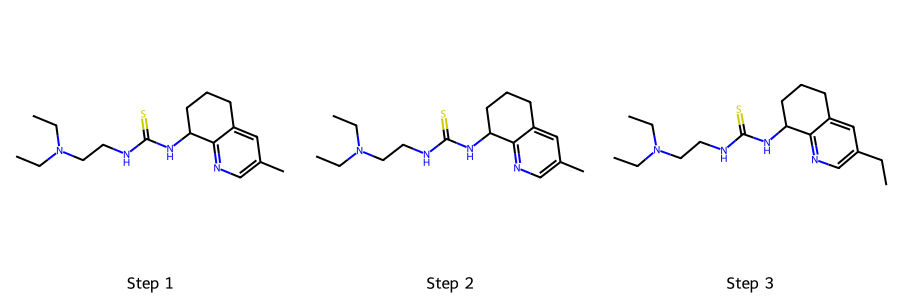

In [6]:
img

In [6]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from peft import PeftModel, PeftConfig
from datetime import datetime
import logging
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
import pandas as pd
import os

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(f'bio_retro_prediction_{datetime.utcnow().strftime("%Y%m%d_%H%M%S")}.log'),
        logging.StreamHandler()
    ]
)

class BioTerminalBuildingBlocks:
    """Class to handle creation and loading of terminal biological building blocks"""
    
    def __init__(self, data_dir="bio_building_blocks"):
        self.data_dir = data_dir
        self.dataset_path = os.path.join(data_dir, "bio_terminal_blocks.csv")
        os.makedirs(data_dir, exist_ok=True)
        
    def create_dataset(self):
        """Create a dataset of terminal biological building blocks that cannot be broken down further"""
        
        # Terminal building blocks in biological systems
        terminal_blocks = {
            # Core building blocks - cannot be broken down further in biological systems
            "Water": "O",
            "Carbon dioxide": "O=C=O",
            "Ammonia": "N",
            "Hydrogen sulfide": "S",
            "Phosphate": "OP(=O)(O)O",
            "Bicarbonate": "OC(=O)[O-]",
            
            # Primary metabolites - considered "terminal" in many biological contexts
            "Acetate": "CC(=O)[O-]",
            "Pyruvate": "CC(=O)C(=O)[O-]",
            "Acetyl-CoA": "CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)([O-])OP(=O)([O-])OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)([O-])[O-]",
            "Glycine": "NCC(=O)O",
            "Serine": "NC(CO)C(=O)O",
            "Alanine": "CC(N)C(=O)O",
            
            # Inorganic ions that are terminal substrates
            "Sodium ion": "[Na+]",
            "Potassium ion": "[K+]",
            "Calcium ion": "[Ca+2]",
            "Magnesium ion": "[Mg+2]",
            "Chloride": "[Cl-]",
            "Sulfate": "O=S(=O)([O-])[O-]",
            "Nitrate": "[O-][N+](=O)[O-]",
            "Ammonium": "[NH4+]",
            
            # Core metabolic building blocks
            "Glucose": "OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@@H]1O",
            "Ribose": "OC[C@H]1OC(O)[C@H](O)[C@@H]1O",
            "Glycerol": "OCC(O)CO",
            "Formate": "O=C[O-]",
            "Methane": "C",
            "Hydrogen gas": "[H][H]",
            "Oxygen gas": "O=O",
            "Nitrogen gas": "N#N",
            
            # Amino acid precursors that are considered terminal
            "Glutamate": "[NH3+][C@@H](CCC(=O)[O-])C(=O)[O-]",
            "Aspartate": "[NH3+][C@@H](CC(=O)[O-])C(=O)[O-]",
            "Glutamine": "NC(=O)CC[C@H](N)C(=O)O",
            "Cysteine": "NC(CS)C(=O)O",
            "Methionine": "CSCCC(N)C(=O)O",
            
            # Essential fatty acids (cannot be synthesized)
            "Linoleic acid": "CCCCCC=CCC=CCCCCCCCC(=O)O",
            "Alpha-linolenic acid": "CCCCC=CCC=CCC=CCCCCCCC(=O)O",
            
            # Nucleotide bases
            "Adenine": "Nc1ncnc2[nH]cnc12",
            "Guanine": "Nc1nc2[nH]cnc2c(=O)[nH]1",
            "Cytosine": "Nc1cc[nH]c(=O)n1",
            "Thymine": "Cc1c[nH]c(=O)[nH]c1=O",
            "Uracil": "O=c1cc[nH]c(=O)[nH]1",
            
            # Vitamins (many are terminal - must be obtained externally)
            "Vitamin B1": "Cc1ncc(C[n+]2csc(CCO)c2C)c(N)n1",
            "Vitamin B2": "Cc1cc2nc3c(=O)[nH]c(=O)nc-3n(C[C@H](O)[C@H](O)[C@H](O)CO)c2cc1C",
            "Vitamin B3": "O=C(O)c1cccnc1",
            "Vitamin B5": "CC(C)(CO)C(O)C(=O)NCCC(=O)O",
            "Vitamin B6": "Cc1ncc(CO)c(CO)c1O",
            "Vitamin B9": "Nc1nc2ncc(CNc3ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc3)nc2c(=O)[nH]1",
            "Vitamin B12": "CN", # Simplified, actual structure too complex
            "Vitamin C": "O=C1OC([C@H](O)CO)C(O)=C1O",
            
            # Trace elements & cofactors
            "Iron(II)": "[Fe+2]",
            "Zinc ion": "[Zn+2]",
            "Copper ion": "[Cu+2]",
            "Selenium": "[Se]",
            "Iodide": "[I-]",
            "Molybdate": "[O-]P(=O)([O-])[O-]",
            "Cobalt ion": "[Co+2]",
            
            # Synthetic precursors
            "Methanol": "CO",
            "Ethanol": "CCO",
            "Formaldehyde": "C=O",
            "Acetaldehyde": "CC=O",
            "Acetic acid": "CC(=O)O",
            "Lactic acid": "CC(O)C(=O)O",
            
            # Energy carriers
            "ATP": "Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O",
            "GTP": "Nc1nc2c(ncn2[C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)[nH]1",
            "NAD+": "NC(=O)c1ccc[n+](c1)[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]2O[C@H]([C@H](O)[C@@H]2O)n2cnc3c(N)ncnc32)[C@@H](O)[C@H]1O",
            "NADP+": "NC(=O)c1ccc[n+](c1)[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]2O[C@H]([C@H](OP(=O)(O)O)[C@@H]2O)n2cnc3c(N)ncnc32)[C@@H](O)[C@H]1O",
            "FAD": "Cc1cc2nc3c(=O)[nH]c(=O)nc-3n(C[C@H](O)[C@H](O)[C@H](O)COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@H]([C@H](O)[C@@H]3O)n3cnc4c(N)ncnc43)c2cc1C",
            
            # Simple sugars
            "Galactose": "OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@@H]1O",
            "Fructose": "OC[C@H]1O[C@](O)(CO)[C@@H](O)[C@H]1O",
            "Mannose": "OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@@H]1O",
            "Xylose": "OC[C@H]1O[C@H](O)[C@H](O)[C@@H]1O",
        }
        
        # Create DataFrame
        df = pd.DataFrame(list(terminal_blocks.items()), columns=['Name', 'SMILES'])
        
        # Validate SMILES
        valid_entries = []
        for _, row in df.iterrows():
            mol = Chem.MolFromSmiles(row['SMILES'])
            if mol is not None:
                valid_entries.append(row)
            else:
                logging.warning(f"Invalid SMILES for {row['Name']}: {row['SMILES']}")
        
        valid_df = pd.DataFrame(valid_entries)
        valid_df.to_csv(self.dataset_path, index=False)
        logging.info(f"Created biological terminal building blocks dataset with {len(valid_df)} valid entries")
        return self.dataset_path
    
    def get_dataset_path(self):
        """Get path to dataset, creating it if it doesn't exist"""
        if not os.path.exists(self.dataset_path):
            return self.create_dataset()
        return self.dataset_path

class BiologicalConstraints:
    def __init__(self):
        self.max_molecular_weight = 1000
        self.min_solubility = -2.0
        self.max_rotatable_bonds = 10
        self.max_hba = 10  # Hydrogen bond acceptors
        self.max_hbd = 5   # Hydrogen bond donors

    def validate_molecule(self, smiles):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False, "Invalid SMILES"

            mw = Descriptors.ExactMolWt(mol)
            if mw > self.max_molecular_weight:
                return False, f"MW {mw:.1f} > {self.max_molecular_weight}"

            logP = Descriptors.MolLogP(mol)
            if logP < self.min_solubility:
                return False, f"LogP {logP:.1f} < {self.min_solubility}"
                
            rot_bonds = Descriptors.NumRotatableBonds(mol)
            if rot_bonds > self.max_rotatable_bonds:
                return False, f"Rotatable bonds {rot_bonds} > {self.max_rotatable_bonds}"
                
            hba = Descriptors.NumHAcceptors(mol)
            if hba > self.max_hba:
                return False, f"H-bond acceptors {hba} > {self.max_hba}"
                
            hbd = Descriptors.NumHDonors(mol)
            if hbd > self.max_hbd:
                return False, f"H-bond donors {hbd} > {self.max_hbd}"

            return True, "Pass"
        except Exception as e:
            return False, str(e)

class EnzymePrediction:
    def __init__(self):
        # EC number categories with common examples
        self.ec_classes = {
            "EC 1": "Oxidoreductases", # Dehydrogenases, oxidases, reductases
            "EC 2": "Transferases",    # Kinases, transaminases, methyltransferases
            "EC 3": "Hydrolases",      # Lipases, proteases, glycosidases
            "EC 4": "Lyases",          # Decarboxylases, aldolases, dehydratases
            "EC 5": "Isomerases",      # Epimerases, racemases, isomerases
            "EC 6": "Ligases"          # Synthetases, carboxylases, amino-acid ligases
        }

    def predict_enzyme(self, reactant_smiles, product_smiles):
        try:
            r_mol = Chem.MolFromSmiles(reactant_smiles)
            p_mol = Chem.MolFromSmiles(product_smiles)

            if r_mol is None or p_mol is None:
                return "EC 0.0.0.0"

            # Calculate fingerprints
            r_fp = AllChem.GetMorganFingerprintAsBitVect(r_mol, 2, nBits=2048)
            p_fp = AllChem.GetMorganFingerprintAsBitVect(p_mol, 2, nBits=2048)

            # Calculate Tanimoto similarity
            sim = 1.0 - float(AllChem.DataStructs.FingerprintSimilarity(r_fp, p_fp))
            
            # Simple logic to classify based on fingerprint differences
            if sim > 0.6:
                return "EC 1.-.-.-"  # Oxidoreductases for significant changes
            elif sim > 0.4:
                return "EC 2.-.-.-"  # Transferases for moderate changes
            elif sim > 0.2:
                return "EC 3.-.-.-"  # Hydrolases for smaller changes
            else:
                return "EC 4.-.-.-"  # Lyases for minimal changes
        except Exception as e:
            logging.warning(f"Enzyme prediction error: {str(e)}")
            return "EC 0.0.0.0"

class RetroSynthesisPathway:
    def __init__(self, starting_materials_file):
        self.starting_materials = self.load_starting_materials(starting_materials_file)
        self.max_steps = 10
        self.threshold_complexity = 0.7
        logging.info(f"Loaded {len(self.starting_materials)} terminal building blocks.")

    def load_starting_materials(self, path):
        try:
            df = pd.read_csv(path)
            # Create dictionary mapping SMILES to compound names
            smiles_to_name = dict(zip(df['SMILES'], df['Name']))
            logging.info(f"Terminal building blocks: {', '.join(df['Name'].tolist()[:5])}...")
            return smiles_to_name
        except Exception as e:
            logging.error(f"Error loading starting materials: {str(e)}")
            return {}

    def is_starting_material(self, smiles):
        """Check if a compound is a terminal building block"""
        return smiles in self.starting_materials

    def get_starting_material_name(self, smiles):
        """Get the name of a terminal building block"""
        return self.starting_materials.get(smiles, "Unknown")

    def calculate_complexity(self, smiles):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None: return 1.0
            n_atoms = mol.GetNumAtoms()
            n_rings = len(Chem.GetSSSR(mol))
            n_chiral = len(Chem.FindMolChiralCenters(mol))
            n_rotatable = Descriptors.NumRotatableBonds(mol)
            complexity = (n_atoms + 2 * n_rings + 3 * n_chiral + n_rotatable) / 100.0
            return min(complexity, 1.0)
        except Exception as e:
            logging.warning(f"Complexity calculation error: {str(e)}")
            return 1.0

class BeamSearchNode:
    def __init__(self, smiles, score):
        self.smiles = smiles
        self.score = score
        
    def __lt__(self, other):
        return self.score > other.score  # Higher scores are better

def load_model_and_tokenizer(model_path):
    try:
        tokenizer = AutoTokenizer.from_pretrained("sagawa/ReactionT5v2-retrosynthesis-USPTO_50k")
        peft_config = PeftConfig.from_pretrained(model_path)
        base_model = AutoModelForSeq2SeqLM.from_pretrained(
            peft_config.base_model_name_or_path,
            torch_dtype=torch.float16,
            device_map="auto"
        )
        model = PeftModel.from_pretrained(base_model, model_path)
        model.eval()
        return model, tokenizer
    except Exception as e:
        logging.error(f"Model loading failed: {str(e)}")
        raise

def predict_multistep_synthesis(smiles_input, model, tokenizer, pathway):
    bio_checker = BiologicalConstraints()
    enzyme_predictor = EnzymePrediction()
    
    # Store synthesis tree
    synthesis_tree = []
    
    def generate_step(smiles):
        inputs = tokenizer(smiles, return_tensors="pt", padding=True)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_length=128,
                num_beams=5,
                num_return_sequences=3,
                early_stopping=True,
                output_scores=True,
                return_dict_in_generate=True
            )

        predictions = []
        for seq, score in zip(outputs.sequences, outputs.sequences_scores):
            decoded = tokenizer.decode(seq, skip_special_tokens=True)
            if Chem.MolFromSmiles(decoded):
                predictions.append(BeamSearchNode(decoded, score.item()))
        return predictions

    # Initialize queue with target molecule
    queue = [(smiles_input, 0, [])]  # (smiles, depth, path)
    seen = set()
    
    # Track completed pathways
    completed_pathways = []

    while queue and len(completed_pathways) < 5:  # Limit to finding 5 complete pathways
        curr_smiles, depth, path = queue.pop(0)
        
        if curr_smiles in seen:
            continue
        seen.add(curr_smiles)
        
        # Check if we've reached a terminal building block
        if pathway.is_starting_material(curr_smiles):
            # We found a complete pathway
            terminal_name = pathway.get_starting_material_name(curr_smiles)
            complete_path = path + [(curr_smiles, terminal_name, True)]
            completed_pathways.append(complete_path)
            continue
            
        # Check if we've reached maximum depth
        if depth >= pathway.max_steps:
            continue
            
        # Generate predictions for next step
        predictions = generate_step(curr_smiles)
        
        for pred in predictions:
            # Validate molecule
            valid, reason = bio_checker.validate_molecule(pred.smiles)
            if not valid:
                continue
                
            # Get enzyme prediction
            enzyme = enzyme_predictor.predict_enzyme(pred.smiles, curr_smiles)
            
            # Check if prediction is a terminal building block
            is_terminal = pathway.is_starting_material(pred.smiles)
            terminal_name = pathway.get_starting_material_name(pred.smiles) if is_terminal else ""
            
            # Add to path
            new_path = path + [(curr_smiles, enzyme, False)]
            
            if is_terminal:
                # Complete pathway
                complete_path = new_path + [(pred.smiles, terminal_name, True)]
                completed_pathways.append(complete_path)
            else:
                # Continue search if compound isn't too complex
                complexity = pathway.calculate_complexity(pred.smiles)
                if complexity < pathway.threshold_complexity:
                    queue.append((pred.smiles, depth + 1, new_path))
                    
    # Format results for printing
    results = {
        'target': smiles_input,
        'pathways': completed_pathways
    }
    
    return results

def download_model_if_needed(model_path):
    """Download the model if it doesn't exist locally"""
    if os.path.exists(model_path):
        return model_path
    
    # This is a placeholder - in a real implementation you would need to download the model
    logging.info(f"Model not found at {model_path}. In a real implementation, you would download it here.")
    logging.info(f"For now, we'll continue with the assumption the model exists.")
    return model_path

def print_synthesis_pathway(pathway_data):
    """Format and print synthesis pathway data"""
    print("\n" + "="*80)
    print(f"TARGET MOLECULE: {pathway_data['target']}")
    print("="*80)
    
    if not pathway_data['pathways']:
        print("No complete synthesis pathways found.")
        return
        
    for i, pathway in enumerate(pathway_data['pathways'], 1):
        print(f"\nPATHWAY {i} ({len(pathway)} steps):")
        print("-" * 60)
        
        # Print the pathway in reverse (from target to building blocks)
        current_indent = 0
        for j, (smiles, info, is_terminal) in enumerate(pathway):
            if j == 0:
                # First entry is always the target molecule
                print(f"Starting molecule: {smiles}")
            elif is_terminal:
                # Terminal building block
                print(f"{' '*current_indent}└── TERMINAL BLOCK: {info} ({smiles})")
            else:
                # Intermediate with enzyme
                print(f"{' '*current_indent}├── Step {j}: {smiles}")
                print(f"{' '*current_indent}│   Enzyme: {info}")
                current_indent += 4
        
        print("-" * 60)

def main():
    try:
        # Setup working directory
        os.makedirs("models", exist_ok=True)
        model_path = "/kaggle/input/bioretrosynthesis_final/pytorch/default/1"
        
        # Create or get dataset
        dataset_manager = BioTerminalBuildingBlocks()
        terminal_blocks_file = dataset_manager.get_dataset_path()
        
        # Example test molecule (Aspirin)
        test_smiles = "Nc1ccc(Cl)cc1OC(=O)O"
        
        # Ensure model exists (download if needed)
        model_path = download_model_if_needed(model_path)
        
        # Normal flow continues
        model, tokenizer = load_model_and_tokenizer(model_path)
        pathway = RetroSynthesisPathway(terminal_blocks_file)

        logging.info(f"Running bio-retrosynthesis for: {test_smiles}")
        result = predict_multistep_synthesis(test_smiles, model, tokenizer, pathway)

        # Print results directly
        print_synthesis_pathway(result)
        
        logging.info(f"Bio-retrosynthesis prediction completed.")
    except Exception as e:
        logging.error(f"Execution failed: {str(e)}")

if __name__ == "__main__":
    main()


TARGET MOLECULE: Nc1ccc(Cl)cc1OC(=O)O
No complete synthesis pathways found.


[13:59:46] SMILES Parse Error: extra open parentheses for input: 'O=C(Oc1cc(Cl'
[13:59:46] SMILES Parse Error: extra open parentheses for input: 'O=C(O)Oc1cc(Cl'
[13:59:46] SMILES Parse Error: extra open parentheses for input: 'O=C(O)Nc1ccc(Cl'


In [6]:
import torch
import sys
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline


# 2) Point to your local DeepSeek‑R1 model directory
local_model_dir = "/kaggle/input/deepseek-r1/transformers/deepseek-r1/2"

# 3) Load tokenizer & model with trust_remote_code
tokenizer = AutoTokenizer.from_pretrained(
    local_model_dir,
    trust_remote_code=True,      # allow loading custom code :contentReference[oaicite:4]{index=4}
    local_files_only=True        # avoid remote downloads
)

model = AutoModelForSeq2SeqLM.from_pretrained(
    local_model_dir,
    trust_remote_code=True,      # execute the model’s own architecture code
    local_files_only=True
).to("cuda" if torch.cuda.is_available() else "cpu")

# 4) Create a text2text-generation pipeline
explainer = pipeline(
    task="text2text-generation",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1
)  # HF pipeline abstracts generation details :contentReference[oaicite:5]{index=5}

# 5) Prepare and explain your retrosynthesis summary
path_summary = """
Prediction Summary:
Target molecule: N[C@@H](Cc1ccccc1)C(=O)O
Number of steps: 4

Step 1:
Substrate: N[C@@H](Cc1ccccc1)C(=O)O
Product: N[C@@H](Cc1ccccc1)C(=O)O

Step 2:
Substrate: N[C@@H](Cc1ccccc1)C(=O)O
Product: COC(=O)[C@@H](N)Cc1ccccc1

Step 3:
Substrate: N[C@@H](Cc1ccccc1)C(=O)O
Product: N[C@@H](Cc1ccc(O)cc1)C(=O)O

Step 4:
Substrate: COC(=O)[C@@H](N)Cc1ccccc1
Product: COC(=O)[C@@H](N)Cc1ccccc1
"""
prompt = "Explain this retrosynthesis pathway step by step:\n" + path_summary

response = explainer(
    prompt,
    max_length=512,
    do_sample=False            # deterministic decoding :contentReference[oaicite:6]{index=6}
)[0]["generated_text"]

print("\n=== Retrosynthesis Explanation ===\n")
print(response)


ValueError: Unrecognized configuration class <class 'transformers_modules.2.configuration_deepseek.DeepseekV3Config'> for this kind of AutoModel: AutoModelForSeq2SeqLM.
Model type should be one of BartConfig, BigBirdPegasusConfig, BlenderbotConfig, BlenderbotSmallConfig, EncoderDecoderConfig, FSMTConfig, GPTSanJapaneseConfig, LEDConfig, LongT5Config, M2M100Config, MarianConfig, MBartConfig, MT5Config, MvpConfig, NllbMoeConfig, PegasusConfig, PegasusXConfig, PLBartConfig, ProphetNetConfig, Qwen2AudioConfig, SeamlessM4TConfig, SeamlessM4Tv2Config, SwitchTransformersConfig, T5Config, UMT5Config, XLMProphetNetConfig.

In [1]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 21.6 MB/s eta 0:00:00:00:0100:01


In [4]:
# Setup the environment
!pip install accelerate
!pip install -i https://pypi.org/simple/ bitsandbytes
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import kagglehub
# Load the model
# kagglehub.login()
# kagglehub.model_download('google/gemma/transformers/1.1-7b-it/1/')
quantization_config = BitsAndBytesConfig(load_in_4bit=True)
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/gemma/transformers/1.1-2b-it/1")
model = AutoModelForCausalLM.from_pretrained(
    "/kaggle/input/gemma/transformers/1.1-2b-it/1",
    quantization_config=quantization_config
)
# Use the model
input_text = """ convert the similes format to their chemical name and explain the bio retrosynthesis pathway - 
Prediction Summary:
Target molecule: N[C@@H](Cc1ccccc1)C(=O)O
Number of steps: 4

Step 1:
Substrate: N[C@@H](Cc1ccccc1)C(=O)O
Product: N[C@@H](Cc1ccccc1)C(=O)O

Step 2:
Substrate: N[C@@H](Cc1ccccc1)C(=O)O
Product: COC(=O)[C@@H](N)Cc1ccccc1

Step 3:
Substrate: N[C@@H](Cc1ccccc1)C(=O)O
Product: N[C@@H](Cc1ccc(O)cc1)C(=O)O

Step 4:
Substrate: COC(=O)[C@@H](N)Cc1ccccc1
Product: COC(=O)[C@@H](N)Cc1ccccc1
"""
input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**input_ids)
print(tokenizer.decode(outputs[0]))


Looking in indexes: https://pypi.org/simple/


`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

<bos> convert the similes format to their chemical name and explain the bio retrosynthesis pathway - 
Prediction Summary:
Target molecule: N[C@@H](Cc1ccccc1)C(=O)O
Number of steps: 4

Step 1:
Substrate: N[C@@H](Cc1ccccc1)C(=O)O
Product: N[C@@H](Cc1ccccc1)C(=O)O

Step 2:
Substrate: N[C@@H](Cc1ccccc1)C(=O)O
Product: COC(=O)[C@@H](N)Cc1ccccc1

Step 3:
Substrate: N[C@@H](Cc1ccccc1)C(=O)O
Product: N[C@@H](Cc1ccc(O)cc1)C(=O)O

Step 4:
Substrate: COC(=O)[C@@H](N)Cc1ccccc1
Product: COC(=O)[C@@H](N)Cc1ccccc1
 

**Chemical Names:**

1. Nitrobenzene
2. Cyclohexanecarbonitrile


In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# 1. Load model (quantized) and tokenizer
quant_config = BitsAndBytesConfig(load_in_4bit=True)
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/gemma/transformers/1.1-2b-it/1")
model = AutoModelForCausalLM.from_pretrained(
    "/kaggle/input/gemma/transformers/1.1-2b-it/1",
    quantization_config=quant_config
).to("cuda")

# 2. Prepare input
input_text = (
    """ convert the similes format to their chemical name and explain the bio retrosynthesis pathway - 
Prediction Summary:
Target molecule: N[C@@H](Cc1ccccc1)C(=O)O
Number of steps: 4

Step 1:
Substrate: N[C@@H](Cc1ccccc1)C(=O)O
Product: N[C@@H](Cc1ccccc1)C(=O)O

Step 2:
Substrate: N[C@@H](Cc1ccccc1)C(=O)O
Product: COC(=O)[C@@H](N)Cc1ccccc1

Step 3:
Substrate: N[C@@H](Cc1ccccc1)C(=O)O
Product: N[C@@H](Cc1ccc(O)cc1)C(=O)O

Step 4:
Substrate: COC(=O)[C@@H](N)Cc1ccccc1
Product: COC(=O)[C@@H](N)Cc1ccccc1
"""
)
input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")

# 3. Generate with plenty of new tokens
outputs = model.generate(
    **input_ids,
    max_new_tokens=500,     # generate up to 500 new tokens :contentReference[oaicite:3]{index=3}
    do_sample=True,         # enable sampling for richer text
    temperature=0.8,        # control randomness
    top_p=0.9,              # nucleus sampling
    repetition_penalty=1.1  # discourage repeated phrases
)

# 4. Decode and print
generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated)


`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

 convert the similes format to their chemical name and explain the bio retrosynthesis pathway - 
Prediction Summary:
Target molecule: N[C@@H](Cc1ccccc1)C(=O)O
Number of steps: 4

Step 1:
Substrate: N[C@@H](Cc1ccccc1)C(=O)O
Product: N[C@@H](Cc1ccccc1)C(=O)O

Step 2:
Substrate: N[C@@H](Cc1ccccc1)C(=O)O
Product: COC(=O)[C@@H](N)Cc1ccccc1

Step 3:
Substrate: N[C@@H](Cc1ccccc1)C(=O)O
Product: N[C@@H](Cc1ccc(O)cc1)C(=O)O

Step 4:
Substrate: COC(=O)[C@@H](N)Cc1ccccc1
Product: COC(=O)[C@@H](N)Cc1ccccc1
**Explanation:**

The retrosynthesis pathway describes a series of reactions that lead to the formation of the original substrate from an alkyl halide. In this case, the retrosynthesis pathway for the given molecule involves four steps.

**Step 1:** Reaction between NOCl and alkyne results in the formation of chloroacetyl chloride.

**Step 2:** Chloracetyl chloride reacts with cyanide ion to form acetyl cyanide, which then rearranges to afford cyclohexanecarbonyl cyanide.

**Step 3:** Cyclohexan